In [10]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import sparse,  io, linalg
import pickle
from tqdm import tqdm_notebook as tqdm
import networkx as nx
import snap
from random import randrange


In [13]:
collaboration = np.loadtxt('collaboration/ca-AstroPh.txt',dtype=int)


In [14]:
# converting edge weight information into graph
collaboration_G = nx.Graph()
for i in tqdm(range(collaboration.shape[0])):
    if collaboration_G.has_edge(collaboration[i,0],collaboration[i,1]):
        collaboration_G[collaboration[i,0]][collaboration[i,1]]['weight']+=1
    else:
        collaboration_G.add_edge(collaboration[i,0],collaboration[i,1],weight=1)


In [15]:
for e in tqdm(collaboration_G.edges()):
    collaboration_G[e[0]][e[1]]['weight_inv']=1/float(collaboration_G[e[0]][e[1]]['weight'])
    collaboration_G[e[0]][e[1]]['weight_inv_exp']=np.exp(-float(collaboration_G[e[0]][e[1]]['weight'])/3.0)


In [16]:
# This is the code for mutual neighbors vs message plot
# Each point in the plot is (wt,sim) for an edge e
# where wt is the weight weight of edge e normalized by the total wweight incident on the end points
# the value sim is any measure of similarity between the nodes 
# that is purely based on the structure of the graph and not on the weights
# The corresponding log log graph seems to be a straight line with positive slope
pwl = []
for e in tqdm(collaboration_G.edges()):
    wt = collaboration_G[e[0]][e[1]]['weight']/float(collaboration_G.degree(e[0],weight='weight')+collaboration_G.degree(e[1],weight='weight'))
    nbr1 = set(collaboration_G.neighbors(e[0]))
    nbr2 = set(collaboration_G.neighbors(e[1]))
    common_nbrs= set.intersection(nbr1,nbr2)
    all_nbrs = set.union(nbr1,nbr2)
    sim = sum([1/np.log(len(collaboration_G.neighbors(v))) for v in common_nbrs])/sum(
        [1/np.log(len(collaboration_G.neighbors(v))) for v in all_nbrs])
    #sim = len(set.intersection(nbr1,nbr2))/float(len(set.union(nbr1,nbr2)))
    #sim = len(set.intersection(nbr1,nbr2))
    pwl += [(wt, sim)]


/Users/rohan_varma/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in double_scalars
/Users/rohan_varma/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in double_scalars
/Users/rohan_varma/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars


In [17]:
# This function plots two things
# A log-log scatter plots of the records
# A summary line which basically plots for each x, the median value of y
# The summary line plots this for B values of x placed equidistant
# Set discrete to True if the input values of x are already bucketed into discrete values e.g.,
# when we plot self-similarity graph for log-log
# Input:
# records is a numpy array of two columns -- the output is a plot of log (first column) 
# log(second column)
# summary is a fuction that takes as input a 1-D np array and outputs a single summary value

def plot_log_log_summary(records,B=20,summary=np.median, discrete=False):
    fig, ax = plt.subplots()
    records = records[np.array([idx for idx in range(records.shape[0]) if records[idx, 0]>0 and records[idx,1] > 0]),:]


    xs = [np.log(record[0]) for record in records]
    ys = [np.log(record[1]) for record in records]
    plt.scatter([(x) for x in xs], [(y) for y in  ys],s=0.5)


    if discrete==False:
        x_max = max(xs) - min(xs)
        # bin into default 20 values
        binned_xs = [min(xs)+(x_max*i)/float(B) for i in range(B+1)]
        median_ys = []
        err = []
        for i in range(B):
            # find median y values for x values in [binned_xs[i], binned_xs[i+1])
            current_ys = [ys[j] for j in range(len(xs)) if binned_xs[i] <= xs[j] and xs[j] < binned_xs[i+1]]
            current_y = summary(current_ys)
            median_ys += [current_y]
            #err += [[median_ys-np.std(current_ys)*0.5,median_ys+np.std(current_ys)*0.5]]
            err += [np.std(current_ys)]
        plt.errorbar(binned_xs[1:], median_ys, marker='o', yerr=err,color='r')
    else:
        binned_xs = np.unique(xs)
        median_ys = []
        err = []
        for x in binned_xs:
            current_ys = [ys[j] for j in range(len(xs)) if xs[j] == x]
            current_y = summary(current_ys)
            median_ys += [current_y]
            #err += [[median_ys-np.std(current_ys)*0.5,median_ys+np.std(current_ys)*0.5]]
            err += [np.std(current_ys)]
        plt.errorbar(binned_xs, median_ys, marker='o', yerr=err,color='r')



<IPython.core.display.Javascript object>


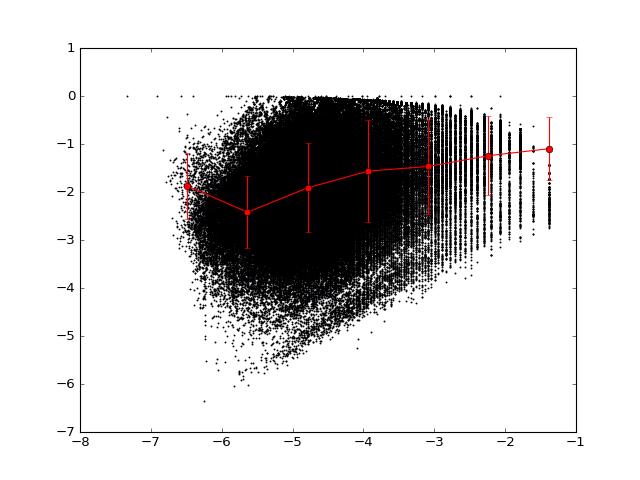

In [18]:
#fig, ax = plt.subplots()
pwl=np.asarray(pwl)
#plt.scatter([r for r in pwl[:,0]], [r for r in  pwl[:,1]],s=0.5)
#plot_median(pwl,B=10)
#plot_log_log(pwl)
plot_log_log_summary(pwl,B=7,summary=np.median)
#plot_summary(pwl,B=7)


#pwl


In [19]:
pwl = []
random_index = randrange(0,len(foo))
for node in tqdm(collaboration_G.nodes()):
    for d in [0.04,0.08,0.16,0.32,0.64,1.0,2.0]:
        pwl += [(d,len(nx.single_source_dijkstra_path_length(collaboration_G,node,cutoff=d,weight='weight_inv')))]
pwl=np.asarray(pwl)


<IPython.core.display.Javascript object>


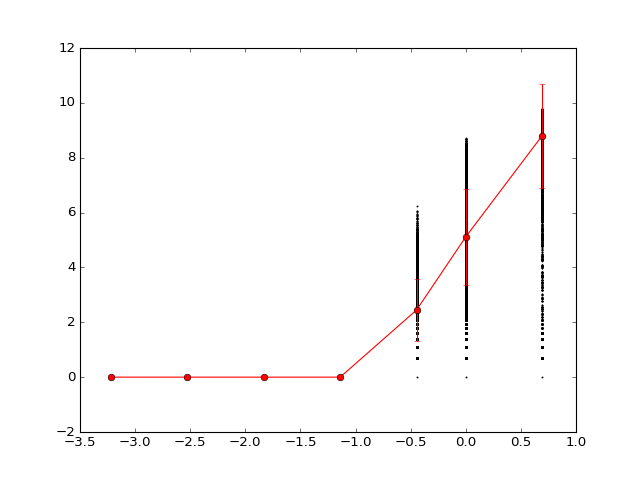

In [20]:
plot_log_log_summary(np.asarray(pwl),discrete=True,summary=np.mean)
